In [ ]:
 !pip install python-igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 50.0 MB/s eta 0:00:00


In [ ]:
####UTILS-VERSION2-####
import numpy as np
from scipy.special import expit as sigmoid
import igraph as ig
import random


def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)


def is_dag(W):
    G = ig.Graph.Weighted_Adjacency(W.tolist())
    return G.is_dag()


def simulate_dag(d, s0, graph_type):
    """Simulate random DAG with some expected number of edges.

    Args:
        d (int): num of nodes
        s0 (int): expected num of edges
        graph_type (str): ER, SF, BP

    Returns:
        B (np.ndarray): [d, d] binary adj matrix of DAG
    """
    def _random_permutation(M):
        # np.random.permutation permutes first axis only
        P = np.random.permutation(np.eye(M.shape[0]))
        return P.T @ M @ P

    def _random_acyclic_orientation(B_und):
        return np.tril(_random_permutation(B_und), k=-1)

    def _graph_to_adjmat(G):
        return np.array(G.get_adjacency().data)

    if graph_type == 'ER':
        # Erdos-Renyi
        G_und = ig.Graph.Erdos_Renyi(n=d, m=s0)
        B_und = _graph_to_adjmat(G_und)
        B = _random_acyclic_orientation(B_und)
    elif graph_type == 'SF':
        # Scale-free, Barabasi-Albert
        G = ig.Graph.Barabasi(n=d, m=int(round(s0 / d)), directed=True)
        B = _graph_to_adjmat(G)
    elif graph_type == 'BP':
        # Bipartite, Sec 4.1 of (Gu, Fu, Zhou, 2018)
        top = int(0.2 * d)
        G = ig.Graph.Random_Bipartite(top, d - top, m=s0, directed=True, neimode=ig.OUT)
        B = _graph_to_adjmat(G)
    else:
        raise ValueError('unknown graph type')
    B_perm = _random_permutation(B)
    assert ig.Graph.Adjacency(B_perm.tolist()).is_dag()
    return B_perm


def simulate_parameter(B, w_ranges=((-1, 0), (0, 2))):
    """Simulate SEM parameters for a DAG.

    Args:
        B (np.ndarray): [d, d] binary adj matrix of DAG
        w_ranges (tuple): disjoint weight ranges

    Returns:
        W (np.ndarray): [d, d] weighted adj matrix of DAG
    """
    W = np.zeros(B.shape)
    S = np.random.randint(len(w_ranges), size=B.shape)  # which range
    for i, (low, high) in enumerate(w_ranges):
        U = np.random.uniform(low=low, high=high, size=B.shape)
        W += B * (S == i) * U
    #W[W < 0] = 0
    return W


def simulate_linear_sem(W, n, sem_type, noise_scale=None, return_noise=False):
    """Simulate samples from linear SEM with specified type of noise.

    For uniform, noise z ~ uniform(-a, a), where a = noise_scale.

    Args:
        W (np.ndarray): [d, d] weighted adj matrix of DAG
        n (int): num of samples, n=inf mimics population risk
        sem_type (str): gauss, exp, gumbel, uniform, logistic, poisson
        noise_scale (np.ndarray): scale parameter of additive noise, default all ones

    Returns:
        X (np.ndarray): [n, d] sample matrix, [d, d] if n=inf
    """
    def _simulate_single_equation(X, w, scale):
        """X: [n, num of parents], w: [num of parents], x: [n]"""
        if sem_type == 'gauss':
            z = 0.01 * np.random.normal(scale=scale, size=n)
            #print("z is the noise fellas",z)
            x = X @ w + z
        elif sem_type == 'exp':
            z = np.random.exponential(scale=scale, size=n)
            x = X @ w + z
        elif sem_type == 'gumbel':
            z = np.random.gumbel(scale=scale, size=n)
            x = X @ w + z
        elif sem_type == 'uniform':
            z = np.random.uniform(low=-scale, high=scale, size=n)
            x = X @ w + z
        elif sem_type == 'logistic':
            x = np.random.binomial(1, sigmoid(X @ w)) * 1.0
        elif sem_type == 'poisson':
            x = np.random.poisson(np.exp(X @ w)) * 1.0
        else:
            raise ValueError('unknown sem type')
        return x,z

    d = W.shape[0]
    if noise_scale is None:
        scale_vec = np.ones(d)
    elif np.isscalar(noise_scale):
        scale_vec = noise_scale * np.ones(d)
    else:
        if len(noise_scale) != d:
            raise ValueError('noise scale must be a scalar or has length d')
        scale_vec = noise_scale
    if not is_dag(W):
        raise ValueError('W must be a DAG')

    if np.isinf(n):  # population risk for linear gauss SEM
        if sem_type == 'gauss':
            # make 1/d X'X = true cov
            X = np.sqrt(d) * np.diag(scale_vec) @ np.linalg.inv(np.eye(d) - W)
            return X
        else:
            raise ValueError('population risk not available')
    # empirical risk
    G = ig.Graph.Weighted_Adjacency(W.tolist())
    ordered_vertices = G.topological_sorting()
    assert len(ordered_vertices) == d
    X = np.zeros([n, d])
    Z = np.zeros([n, d]) if return_noise else None
    for j in ordered_vertices:
        parents = G.neighbors(j, mode=ig.IN)
        #print("the j", j)
        x_j, z_j = _simulate_single_equation(X[:, parents], W[parents, j], scale_vec[j])
        X[:, j] = x_j
        if return_noise and z_j is not None:
            Z[:, j] = z_j

    return (X, Z) if return_noise else X


def simulate_nonlinear_sem(B, n, sem_type, noise_scale=None):
    """Simulate samples from nonlinear SEM.

    Args:
        B (np.ndarray): [d, d] binary adj matrix of DAG
        n (int): num of samples
        sem_type (str): mlp, mim, gp, gp-add
        noise_scale (np.ndarray): scale parameter of additive noise, default all ones

    Returns:
        X (np.ndarray): [n, d] sample matrix
    """
    def _simulate_single_equation(X, scale):
        """X: [n, num of parents], x: [n]"""
        z = np.random.normal(scale=scale, size=n)
        pa_size = X.shape[1]
        if pa_size == 0:
            return z
        if sem_type == 'mlp':
            hidden = 100
            W1 = np.random.uniform(low=0.5, high=2.0, size=[pa_size, hidden])
            W1[np.random.rand(*W1.shape) < 0.5] *= -1
            W2 = np.random.uniform(low=0.5, high=2.0, size=hidden)
            W2[np.random.rand(hidden) < 0.5] *= -1
            x = sigmoid(X @ W1) @ W2 + z
        elif sem_type == 'mim':
            w1 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
            w1[np.random.rand(pa_size) < 0.5] *= -1
            w2 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
            w2[np.random.rand(pa_size) < 0.5] *= -1
            w3 = np.random.uniform(low=0.5, high=2.0, size=pa_size)
            w3[np.random.rand(pa_size) < 0.5] *= -1
            x = np.tanh(X @ w1) + np.cos(X @ w2) + np.sin(X @ w3) + z
        elif sem_type == 'gp':
            from sklearn.gaussian_process import GaussianProcessRegressor
            gp = GaussianProcessRegressor()
            x = gp.sample_y(X, random_state=None).flatten() + z
        elif sem_type == 'gp-add':
            from sklearn.gaussian_process import GaussianProcessRegressor
            gp = GaussianProcessRegressor()
            x = sum([gp.sample_y(X[:, i, None], random_state=None).flatten()
                     for i in range(X.shape[1])]) + z
        else:
            raise ValueError('unknown sem type')
        return x

    d = B.shape[0]
    scale_vec = noise_scale if noise_scale else np.ones(d)
    X = np.zeros([n, d])
    G = ig.Graph.Adjacency(B.tolist())
    ordered_vertices = G.topological_sorting()
    assert len(ordered_vertices) == d
    for j in ordered_vertices:
        parents = G.neighbors(j, mode=ig.IN)
        X[:, j] = _simulate_single_equation(X[:, parents], scale_vec[j])
    return X


import numpy as npgau

def count_accuracy(B_true, B_est):
    """Compute various accuracy metrics for B_est.

    Args:
        B_true (np.ndarray): [d, d] ground truth graph, {0, 1}
        B_est (np.ndarray): [d, d] estimate, {0, 1, -1}, -1 is undirected edge in CPDAG

    Returns:
        dict: accuracy metrics printed vertically
    """
    def is_dag(B):
        return np.all(np.linalg.matrix_power(B, B.shape[0]) == 0)

    if (B_est == -1).any():  # cpdag
        if not ((B_est == 0) | (B_est == 1) | (B_est == -1)).all():
            raise ValueError('B_est should take value in {0,1,-1}')
        if ((B_est == -1) & (B_est.T == -1)).any():
            raise ValueError('undirected edge should only appear once')
    else:  # dag
        if not ((B_est == 0) | (B_est == 1)).all():
            raise ValueError('B_est should take value in {0,1}')
        if not is_dag(B_est):
            #raise ValueError('B_est should be a DAG')
            print("B_est is not A dag ------SERIOUS ISSUE-------")

    d = B_true.shape[0]
    pred_und = np.flatnonzero(B_est == -1)
    pred = np.flatnonzero(B_est == 1)
    cond = np.flatnonzero(B_true)
    cond_reversed = np.flatnonzero(B_true.T)
    cond_skeleton = np.concatenate([cond, cond_reversed])

    true_pos = np.intersect1d(pred, cond, assume_unique=True)
    true_pos_und = np.intersect1d(pred_und, cond_skeleton, assume_unique=True)
    true_pos = np.concatenate([true_pos, true_pos_und])

    false_pos = np.setdiff1d(pred, cond_skeleton, assume_unique=True)
    false_pos_und = np.setdiff1d(pred_und, cond_skeleton, assume_unique=True)
    false_pos = np.concatenate([false_pos, false_pos_und])

    extra = np.setdiff1d(pred, cond, assume_unique=True)
    reverse = np.intersect1d(extra, cond_reversed, assume_unique=True)

    false_negative = np.setdiff1d(cond, pred, assume_unique=True)

    pred_size = len(pred) + len(pred_und)
    cond_neg_size = 0.5 * d * (d - 1) - len(cond)

    fdr = float(len(reverse) + len(false_pos)) / max(pred_size, 1)
    tpr = float(len(true_pos)) / max(len(cond), 1)
    fpr = float(len(reverse) + len(false_pos)) / max(cond_neg_size, 1)

    pred_lower = np.flatnonzero(np.tril(B_est + B_est.T))
    cond_lower = np.flatnonzero(np.tril(B_true + B_true.T))
    extra_lower = np.setdiff1d(pred_lower, cond_lower, assume_unique=True)
    missing_lower = np.setdiff1d(cond_lower, pred_lower, assume_unique=True)
    shd = len(extra_lower) + len(missing_lower) + len(reverse)

    result = {
        'fdr': fdr,
        'tpr': tpr,
        'fpr': fpr,
        'shd': shd,
        'nnz': pred_size,
        'reverse': len(reverse),
        'false_positive': len(false_pos),
        'false_negative': len(false_negative),
        'edge_intersection_count': len(true_pos)
    }

    print("Accuracy Metrics:")
    for k, v in result.items():
        print(f"{k}: {v}")

    return result




In [ ]:
import numpy as np
import scipy.linalg as slin
import scipy.optimize as sopt
from scipy.special import expit as sigmoid

def linear(X,z, lambda1,  max_iter=1000, pruning_threshold=1e9, h_tol=1e-15, rho_max=1e+16,max_inner_iter=100, w_threshold=0.3, A=0 , B=0):
    n, d = X.shape
    #X = X - np.mean(X, axis=0, keepdims=True)
    W = np.random.uniform(low=0.1, high=1.5, size=(d, d))
    #print("main W", W)
    np.fill_diagonal(W, 0.0)
    Lambda = np.random.uniform(low=1e-5, high=1e-4, size=(d, d))
    np.fill_diagonal(Lambda,1e9)
    sigma2 =  np.var(z, axis=0)
    #print("FIXED VALUES OF SIGMA2= " , sigma2, " \n")
    # print("FIXED VALUES OF LAMBDA= " , Lambda, " \n")
    # print("INITIAL VALUES OF W= " , W, " \n")
    #print("FIXED VALUES OF X= " , X, " \n")
    w_new = None

    w_est = np.concatenate((W.flatten(), np.zeros_like(W.flatten())))
    bnds = [(0, 0) if i == j else (0, None) for _ in range(2) for i in range(d) for j in range(d)]
    loss_history = []
    a = A
    b= B
    def _h(W):
        """Evaluate value and gradient of acyclicity constraint."""
        E = slin.expm(W * W)  # (Zheng et al. 2018)
        h = np.trace(E) - d
        G_h = E.T * W * 2
        return h, G_h
    def _loss(W):
        loss = 0
        G = np.zeros_like(W)
        for k in range(d):
            res = X[:, k] - X @ W[:, k]
            loss += 0.5  /d/ sigma2[k] * np.sum(res ** 2)
            G[:, k] = -1.0 /d/ sigma2[k] * X.T @ res
        reg = 0.5 * np.sum(Lambda * (W ** 2))
        gamma_prior = - np.sum((a - 0.5) * np.log(Lambda)) + b * np.sum(Lambda)
        # print("LAMBDA,", Lambda)
        # print(gamma_prior, "-this is the gamma prior")

        G_reg = Lambda * W
        return loss + reg+ gamma_prior, G + G_reg
    def _adj(w):
        """Convert doubled variables ([2 d^2] array) back to original variables ([d, d] matrix)."""
        return (w[:d * d] - w[d * d:]).reshape([d, d])

    def _func(w):
        """Evaluate value and gradient of augmented Lagrangian for doubled variables ([2 d^2] array)."""
        W = _adj(w)
        loss, G_loss = _loss(W)
        h, G_h = _h(W)
        obj = loss + 0.5 * rho * h * h + alpha * h
        G_smooth = G_loss + (rho * h + alpha) * G_h
        g_obj = np.concatenate((G_smooth + lambda1, - G_smooth + lambda1), axis=None)
        return obj, g_obj


    rho, alpha, h = 1, 0.0004, np.inf
    bnds = [(0, 0) if i == j else (0, None) for _ in range(2) for i in range(d) for j in range(d)]
    for o in range(max_iter):
                    #if o%50 == 0:
                        #print(f"Outer Iter: {o}")
                    W_prev = _adj(w_est)

                    Lambda_prev = Lambda.copy()
                    for k in range(d):
                            X_k = X[:, k]
                            Lambda_k = Lambda[:, k]
                            Sigma_wk_inv = (1 / sigma2[k]) * X.T @ X + np.diag(Lambda_k)
                            #print(np.diag(Lambda_k),"----diagonal")
                            Sigma_wk = np.linalg.inv(Sigma_wk_inv)
                            #print(Sigma_wk, "sigma-sqr")
                            mu_wk = (1 / sigma2[k]) * Sigma_wk @ X.T @ X_k
                            #print(mu_wk, "meaaan")
                            for j in range(d):
                                      numerator = 1 - Lambda[j, k] * Sigma_wk[j, j]
                                      if numerator<0:
                                        print("hit neg, blow up")
                                        Lambda[j,k]= pruning_threshold
                                      else:
                                        Lambda[j, k] = numerator / (mu_wk[j] ** 2 + 0.0001)
                                        Lambda[j, k] = min(Lambda[j, k], pruning_threshold)



                    for i in range(max_inner_iter):

                            while rho < rho_max:
                                sol = sopt.minimize(_func, w_est, method='L-BFGS-B', jac=True, bounds=bnds)
                                w_new = sol.x
                                h_new, _ = _h(_adj(w_new))
                                if h_new > 0.25 * h:
                                    rho *= 10
                                else:
                                    break
                            #if o%50 == 0:
                                #print(h_new, i, o)
                            w_est, h = w_new, h_new
                            alpha += rho * h
                            if h <= h_tol or rho >= rho_max:
                                #print(f"inner loop convereged at i:{i} ")
                                break
                    W_est = _adj(w_est)
                    #print("W", W)
                    loss_val, _ = _loss(W_est)
                    loss_history.append(loss_val)
                    delta_W = np.linalg.norm(W_est - W_prev)
                    delta_Lambda = np.linalg.norm(Lambda - Lambda_prev)

                    #print(f"  ΔW: {delta_W:.4e}, ΔLambda: {delta_Lambda:.4e}")

                    if delta_W < 1e-6 and delta_Lambda < 1e-5 :
                        # print(f"Outer loop converged: ΔW={delta_W:.4e}, ΔLambda={delta_Lambda:.4e}")
                        # print(o, "- converged at this iteration(outer)")
                        break

    #print("before pruning", W_est)

    W_unpruned = W_est.copy()  # Save unpruned version
    W_est[np.abs(W_est) < w_threshold] = 0
    #print(loss_history)
    #print("after pruning", W_est)
    #print(loss_history)
    return W_unpruned, W_est


if __name__ == '__main__':

    set_random_seed(40)

    n, d, s0, graph_type, sem_type = 20, 25,50, 'ER', 'gauss'
    B_true = simulate_dag(d, s0, graph_type)
    W_true = simulate_parameter(B_true)
    np.savetxt('W_true.csv', W_true, delimiter=',')
    #print("true weight", W_true)
    X,z = simulate_linear_sem(W_true, n, sem_type,return_noise=True)
    #print("this is the noise",z)
    np.savetxt('X.csv', X, delimiter=',')
    np.savetxt('z.csv', z, delimiter=',')

    #print("----------------------------SBL-DAG--------------------------")
    W_unpruned, W_est = linear(X,z, lambda1=0.1, A=0.6, B=0.1, w_threshold=0.16)
    # print("this is the pruned weight",W_unpruned)
    # print("----------------------------------------------------")
    # print("this is estimated weight" ,W_est)
    #assert is_dag(W_est)
    np.savetxt('W_unpruned.csv', W_unpruned, delimiter=',')
    np.savetxt('W_est.csv', W_est, delimiter=',')
    acc =count_accuracy(B_true, W_est != 0)
    print(acc)
    # print("truth", W_true)
    # print("noise", z)

Accuracy Metrics:
fdr: 0.6833333333333333
tpr: 0.38
fpr: 0.164
shd: 69
nnz: 60
reverse: 3
false_positive: 38
false_negative: 31
edge_intersection_count: 19
{'fdr': 0.6833333333333333, 'tpr': 0.38, 'fpr': 0.164, 'shd': 69, 'nnz': 60, 'reverse': 3, 'false_positive': 38, 'false_negative': 31, 'edge_intersection_count': 19}


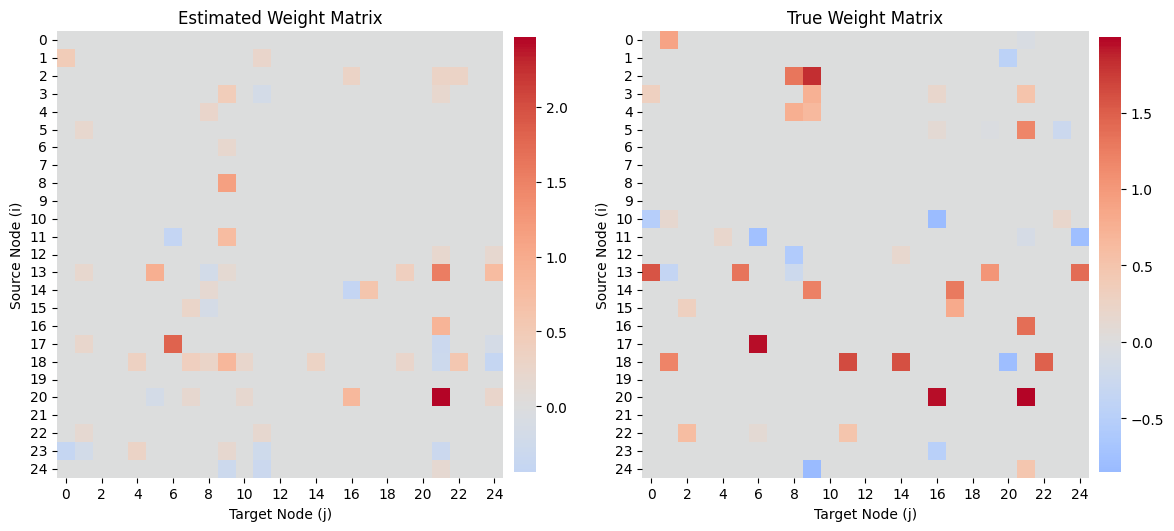

In [ ]:
'''
Accuracy Metrics:
fdr: 0.18421052631578946
tpr: 0.62
fpr: 0.028
shd: 23
nnz: 38
reverse: 3
false_positive: 4
false_negative: 19
edge_intersection_count: 31
{'fdr': 0.18421052631578946, 'tpr': 0.62, 'fpr': 0.028, 'shd': 23, 'nnz': 38, 'reverse': 3, 'false_positive': 4, 'false_negative': 19, 'edge_intersection_count': 31}

'''




import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load matrices
W_est = pd.read_csv("W_est.csv", header=None)
W_true = pd.read_csv("W_true.csv", header=None)

# Subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 9))

# Estimated matrix
hm1 = sns.heatmap(
    W_est, cmap='coolwarm', center=0, ax=axes[0],
    square=True, cbar_kws={"shrink": 0.5, "pad": 0.02}
)
axes[0].set_title("Estimated Weight Matrix")
axes[0].set_xlabel("Target Node (j)")
axes[0].set_ylabel("Source Node (i)")

# True matrix
hm2 = sns.heatmap(
    W_true, cmap='coolwarm', center=0, ax=axes[1],
    square=True, cbar_kws={"shrink": 0.5, "pad": 0.02}
)
axes[1].set_title("True Weight Matrix")
axes[1].set_xlabel("Target Node (j)")
axes[1].set_ylabel("Source Node (i)")

plt.tight_layout()

# Save figure
plt.savefig("weight_matrices_25_50_20.png", dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
'''
n, d, s0, graph_type, sem_type = 1000, 15,30, 'ER', 'gauss'
Accuracy Metrics:
fdr: 0.17391304347826086
tpr: 0.6333333333333333
fpr: 0.05333333333333334
shd: 13
nnz: 23
reverse: 2
false_positive: 2
false_negative: 11
edge_intersection_count: 19
{'fdr': 0.17391304347826086, 'tpr': 0.6333333333333333, 'fpr': 0.05333333333333334, 'shd': 13, 'nnz': 23, 'reverse': 2, 'false_positive': 2, 'false_negative': 11, 'edge_intersection_count': 19}'''



import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load matrices
W_est = pd.read_csv("W_est.csv", header=None)
W_true = pd.read_csv("W_true.csv", header=None)

# Subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 9))

# Estimated matrix
hm1 = sns.heatmap(
    W_est, cmap='coolwarm', center=0, ax=axes[0],
    square=True, cbar_kws={"shrink": 0.5, "pad": 0.02}
)
axes[0].set_title("Estimated Weight Matrix")
axes[0].set_xlabel("Target Node (j)")
axes[0].set_ylabel("Source Node (i)")

# True matrix
hm2 = sns.heatmap(
    W_true, cmap='coolwarm', center=0, ax=axes[1],
    square=True, cbar_kws={"shrink": 0.5, "pad": 0.02}
)
axes[1].set_title("True Weight Matrix")
axes[1].set_xlabel("Target Node (j)")
axes[1].set_ylabel("Source Node (i)")

plt.tight_layout()

# Save figure
plt.savefig("weight_matrices_10.png", dpi=300, bbox_inches='tight')

plt.show()


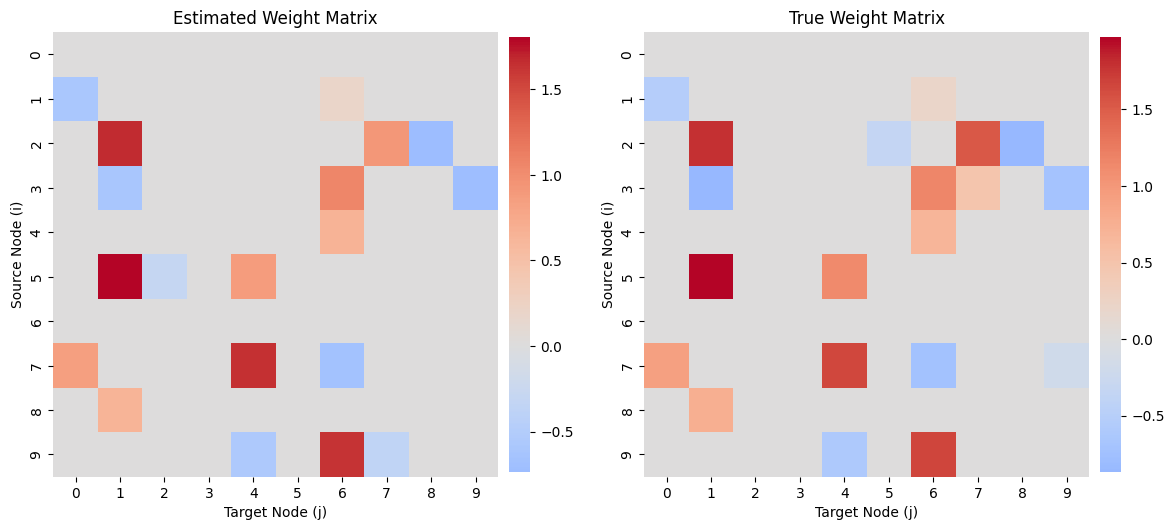

In [ ]:
'''
n, d, s0, graph_type, sem_type = 200, 10,20, 'ER', 'gauss'
Accuracy Metrics:
fdr: 0.10526315789473684
tpr: 0.85
fpr: 0.08
shd: 3
nnz: 19
reverse: 2
false_positive: 0
false_negative: 3
edge_intersection_count: 17
{'fdr': 0.10526315789473684, 'tpr': 0.85, 'fpr': 0.08, 'shd': 3, 'nnz': 19, 'reverse': 2, 'false_positive': 0, 'false_negative': 3, 'edge_intersection_count': 17}

'''



import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load matrices
W_est = pd.read_csv("W_est.csv", header=None)
W_true = pd.read_csv("W_true.csv", header=None)

# Subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 9))

# Estimated matrix
hm1 = sns.heatmap(
    W_est, cmap='coolwarm', center=0, ax=axes[0],
    square=True, cbar_kws={"shrink": 0.5, "pad": 0.02}
)
axes[0].set_title("Estimated Weight Matrix")
axes[0].set_xlabel("Target Node (j)")
axes[0].set_ylabel("Source Node (i)")

# True matrix
hm2 = sns.heatmap(
    W_true, cmap='coolwarm', center=0, ax=axes[1],
    square=True, cbar_kws={"shrink": 0.5, "pad": 0.02}
)
axes[1].set_title("True Weight Matrix")
axes[1].set_xlabel("Target Node (j)")
axes[1].set_ylabel("Source Node (i)")

plt.tight_layout()

# Save figure
plt.savefig("weight_matrices_10_200.png", dpi=300, bbox_inches='tight')

plt.show()


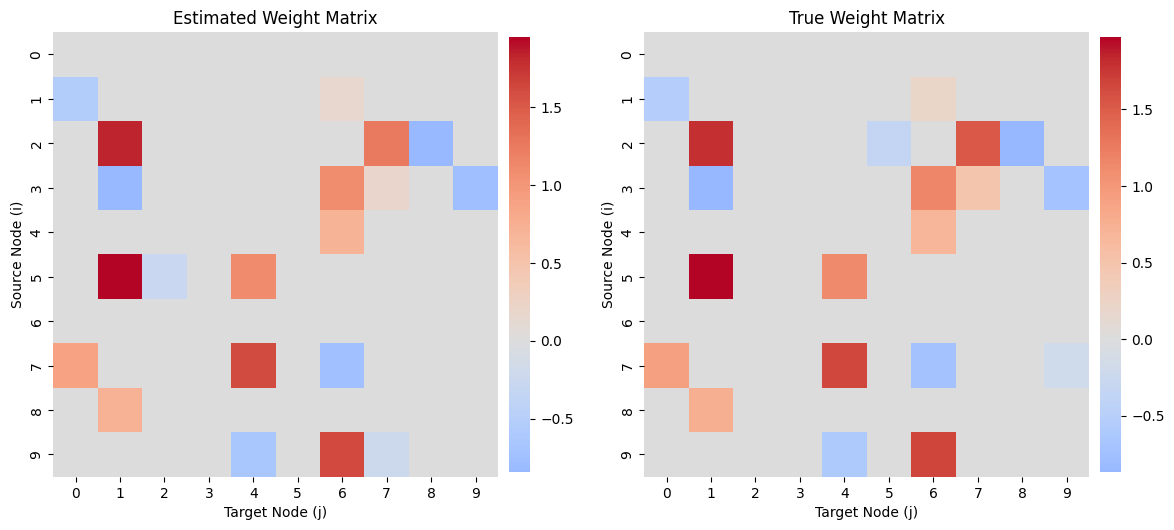

In [ ]:
'''
 n, d, s0, graph_type, sem_type = 1000, 10,20, 'ER', 'gauss'
Accuracy Metrics:
fdr: 0.1
tpr: 0.9
fpr: 0.08
shd: 2
nnz: 20
reverse: 2
false_positive: 0
false_negative: 2
edge_intersection_count: 18
{'fdr': 0.1, 'tpr': 0.9, 'fpr': 0.08, 'shd': 2, 'nnz': 20, 'reverse': 2, 'false_positive': 0, 'false_negative': 2, 'edge_intersection_count': 18}'''



import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load matrices
W_est = pd.read_csv("W_est.csv", header=None)
W_true = pd.read_csv("W_true.csv", header=None)

# Subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 9))

# Estimated matrix
hm1 = sns.heatmap(
    W_est, cmap='coolwarm', center=0, ax=axes[0],
    square=True, cbar_kws={"shrink": 0.5, "pad": 0.02}
)
axes[0].set_title("Estimated Weight Matrix")
axes[0].set_xlabel("Target Node (j)")
axes[0].set_ylabel("Source Node (i)")

# True matrix
hm2 = sns.heatmap(
    W_true, cmap='coolwarm', center=0, ax=axes[1],
    square=True, cbar_kws={"shrink": 0.5, "pad": 0.02}
)
axes[1].set_title("True Weight Matrix")
axes[1].set_xlabel("Target Node (j)")
axes[1].set_ylabel("Source Node (i)")

plt.tight_layout()

# Save figure
plt.savefig("weight_matrices.png", dpi=300, bbox_inches='tight')

plt.show()


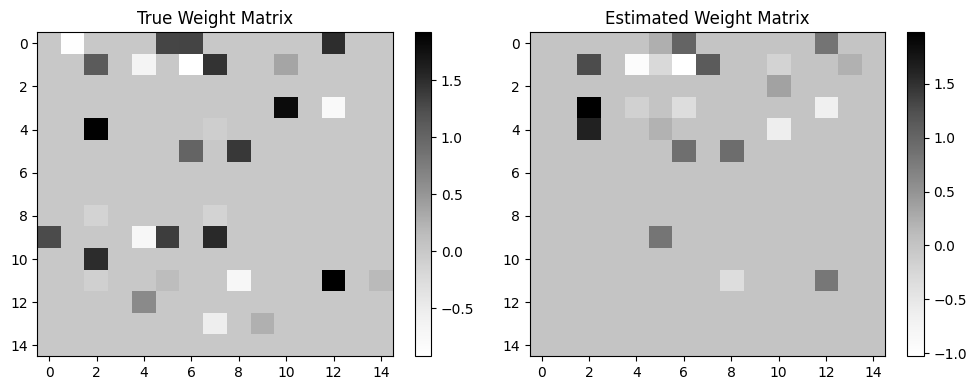

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

W_true = np.loadtxt('W_true.csv', delimiter=',')
W_est = np.loadtxt('W_est.csv', delimiter=',')

plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.imshow(W_true, cmap='Greys', aspect='auto')
plt.title('True Weight Matrix')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(W_est, cmap='Greys', aspect='auto')
plt.title('Estimated Weight Matrix')
plt.colorbar()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

all_results1 = []

sample_sizes = [20, 1000]
node_list = [10, 25, 50]
seeds =[10, 1, 40, 73, 97, 233, 389, 521, 809, 1123]

t = [0.1, 0.08]

for n in sample_sizes:
    print(f"Sample Size: {n}")
    for d in node_list:
        print(f"Nodes: {d}")
        s0 = int(2 * d)  # number of edges
        print(s0)
        for seed in seeds:
            set_random_seed(seed)
            print(f"Seed: {seed}")

            B_true = simulate_dag(d, s0, graph_type='ER')
            W_true = simulate_parameter(B_true)
            X,z = simulate_linear_sem(W_true, n, sem_type='gauss',return_noise=True)
            for k in t:
                W_unpruned, W_est = linear(X,z, lambda1=0.1, A=0.6, B=0.1, w_threshold=k)

                acc =count_accuracy(B_true, W_est != 0)
                #print(acc)
                print("--------")


                for method, acc in [('sbl', acc)]:
                    all_results1.append({
                        'method': method,
                        'n': n,
                        'd': d,
                        't': k,
                        'seed': seed,
                        'fdr': acc['fdr'],
                        'shd': acc['shd'],
                        'edge_intersection': acc['edge_intersection_count']
                    })
df = pd.DataFrame(all_results1)
df.to_csv('dag_threshold_ult_2d.csv', index=False)

Sample Size: 20
Nodes: 10
20
Seed: 10
Accuracy Metrics:
fdr: 0.4117647058823529
tpr: 0.5
fpr: 0.28
shd: 17
nnz: 17
reverse: 0
false_positive: 7
false_negative: 10
edge_intersection_count: 10
--------
Accuracy Metrics:
fdr: 0.47368421052631576
tpr: 0.5
fpr: 0.36
shd: 19
nnz: 19
reverse: 0
false_positive: 9
false_negative: 10
edge_intersection_count: 10
--------
Seed: 1
Accuracy Metrics:
fdr: 0.47619047619047616
tpr: 0.55
fpr: 0.4
shd: 17
nnz: 21
reverse: 2
false_positive: 8
false_negative: 9
edge_intersection_count: 11
--------
Accuracy Metrics:
fdr: 0.4782608695652174
tpr: 0.6
fpr: 0.44
shd: 17
nnz: 23
reverse: 2
false_positive: 9
false_negative: 8
edge_intersection_count: 12
--------
Seed: 40
Accuracy Metrics:
fdr: 0.23809523809523808
tpr: 0.8
fpr: 0.2
shd: 8
nnz: 21
reverse: 1
false_positive: 4
false_negative: 4
edge_intersection_count: 16
--------
Accuracy Metrics:
fdr: 0.2916666666666667
tpr: 0.85
fpr: 0.28
shd: 9
nnz: 24
reverse: 1
false_positive: 6
false_negative: 3
edge_intersec

In [ ]:
df = pd.DataFrame(all_results1)
df.to_csv('dag_threshold_ult_2d.csv', index=False)

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Plot heatmaps for True vs Estimated Weights
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# sns.heatmap(W_true,  cmap='coolwarm', cbar=True)
# plt.title("True Weight Matrix (W_true)")
# plt.xlabel("Nodes")
# plt.ylabel("Nodes")

# plt.subplot(1, 2, 2)
# sns.heatmap(W_est,   cmap='coolwarm',  cbar=True)
# plt.title("Estimated Weight Matrix (W_est)")
# plt.xlabel("Nodes")
# plt.ylabel("Nodes")

# plt.tight_layout()
# plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

all_results1 = []

sample_sizes = [20, 1000]
node_list = [10, 25, 50]
seeds = [10, 40, 1]

for n in sample_sizes:
    print(f"Sample Size: {n}")
    for d in node_list:
        print(f"Nodes: {d}")
        s0 = 2 * d  # number of edges
        for seed in seeds:
            set_random_seed(seed)
            print(f"Seed: {seed}")

            B_true = simulate_dag(d, s0, graph_type='ER')
            W_true = simulate_parameter(B_true)
            X,z = simulate_linear_sem(W_true, n, sem_type='gauss',return_noise=True)


            W_unpruned, W_est = linear(X,z, lambda1=0.1, A=0.6, B=0.1, w_threshold=0.1)

            acc =count_accuracy(B_true, W_est != 0)
            print(acc)


            for method, acc in [('sbl', acc)]:
                all_results1.append({
                    'method': method,
                    'n': n,
                    'd': d,
                    'seed': seed,
                    'fdr': acc['fdr'],
                    'shd': acc['shd'],
                    'edge_intersection': acc['edge_intersection_count']
                })


Sample Size: 20
Nodes: 10
Seed: 10
Accuracy Metrics:
fdr: 0.4117647058823529
tpr: 0.5
fpr: 0.28
shd: 17
nnz: 17
reverse: 0
false_positive: 7
false_negative: 10
edge_intersection_count: 10
{'fdr': 0.4117647058823529, 'tpr': 0.5, 'fpr': 0.28, 'shd': 17, 'nnz': 17, 'reverse': 0, 'false_positive': 7, 'false_negative': 10, 'edge_intersection_count': 10}
Seed: 40


KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(all_results1)
df.to_csv('dag_comparison_results_twice_final.csv', index=False)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

all_results = []

sample_sizes = [20, 1000]
node_list = [10, 25, 50]
seeds = [10, 40, 1, 15, 30, 60]

for n in sample_sizes:
    print(f"Sample Size: {n}")
    for d in node_list:
        print(f"Nodes: {d}")
        s0 = int(d/2)  # number of edges
        print(s0)
        for seed in seeds:
            set_random_seed(seed)
            print(f"Seed: {seed}")

            B_true = simulate_dag(d, s0, graph_type='ER')
            W_true = simulate_parameter(B_true)
            X,z = simulate_linear_sem(W_true, n, sem_type='gauss',return_noise=True)


            W_unpruned, W_est = linear(X,z, lambda1=0.1, A=0.6, B=0.1, w_threshold=0.1)

            acc =count_accuracy(B_true, W_est != 0)
            print(acc)


            for method, acc in [('sbl', acc)]:
                all_results.append({
                    'method': method,
                    'n': n,
                    'd': d,
                    'seed': seed,
                    'fdr': acc['fdr'],
                    'shd': acc['shd'],
                    'edge_intersection': acc['edge_intersection_count']
                })


Sample Size: 20
Nodes: 10
5
Seed: 10
Accuracy Metrics:
fdr: 0.5555555555555556
tpr: 0.8
fpr: 0.125
shd: 6
nnz: 9
reverse: 0
false_positive: 5
false_negative: 1
edge_intersection_count: 4
{'fdr': 0.5555555555555556, 'tpr': 0.8, 'fpr': 0.125, 'shd': 6, 'nnz': 9, 'reverse': 0, 'false_positive': 5, 'false_negative': 1, 'edge_intersection_count': 4}
Seed: 40
Accuracy Metrics:
fdr: 0.5714285714285714
tpr: 0.6
fpr: 0.1
shd: 6
nnz: 7
reverse: 0
false_positive: 4
false_negative: 2
edge_intersection_count: 3
{'fdr': 0.5714285714285714, 'tpr': 0.6, 'fpr': 0.1, 'shd': 6, 'nnz': 7, 'reverse': 0, 'false_positive': 4, 'false_negative': 2, 'edge_intersection_count': 3}
Seed: 1
Accuracy Metrics:
fdr: 0.8333333333333334
tpr: 0.4
fpr: 0.25
shd: 12
nnz: 12
reverse: 1
false_positive: 9
false_negative: 3
edge_intersection_count: 2
{'fdr': 0.8333333333333334, 'tpr': 0.4, 'fpr': 0.25, 'shd': 12, 'nnz': 12, 'reverse': 1, 'false_positive': 9, 'false_negative': 3, 'edge_intersection_count': 2}
Seed: 15
Accuracy 

In [ ]:
df = pd.DataFrame(all_results)
df.to_csv('dag_comparison_results_2_half_final.csv', index=False)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def compute_mse_and_frobenius(W_true, W_est):
    mse = mean_squared_error(W_true.flatten(), W_est.flatten())
    fro = np.linalg.norm(W_true - W_est, ord='fro')
    return mse, fro

all_results = []

sample_sizes = [20, 1000]
node_list = [10, 25, 50]
seeds =[10,  40,  97, 233, 389, 809, 1123]

for n in sample_sizes:
    print(f"Sample Size: {n}")
    for d in node_list:
        print(f"Nodes: {d}")
        s0 = 2*d  # number of edges
        print(s0)
        for seed in seeds:
            set_random_seed(seed)
            print(f"Seed: {seed}")

            B_true = simulate_dag(d, s0, graph_type='ER')
            W_true = simulate_parameter(B_true)
            X,z = simulate_linear_sem(W_true, n, sem_type='gauss',return_noise=True)


            W_unpruned, W_est = linear(X,z, lambda1=0.1, A=0.6, B=0.1, w_threshold=0.1)
            #model = DagmaLinear(loss_type='l2')

            #W_est = model.fit(X, lambda1=0.1)
            mse_no, fro_no = compute_mse_and_frobenius(W_true, W_est)
            acc = count_accuracy(B_true, W_est != 0)
            #print(acc)


            for method, mse, fro in [('dag', mse_no, fro_no)]:
                all_results.append({
                    'method': method,
                    'n': n,
                    'd': d,
                    'seed': seed,
                    'mse': mse,
                    'frobenius': fro
                })


Sample Size: 20
Nodes: 10
20
Seed: 10
Accuracy Metrics:
fdr: 0.4117647058823529
tpr: 0.5
fpr: 0.28
shd: 17
nnz: 17
reverse: 0
false_positive: 7
false_negative: 10
edge_intersection_count: 10
Seed: 40
Accuracy Metrics:
fdr: 0.23809523809523808
tpr: 0.8
fpr: 0.2
shd: 8
nnz: 21
reverse: 1
false_positive: 4
false_negative: 4
edge_intersection_count: 16
Seed: 97
Accuracy Metrics:
fdr: 0.25
tpr: 0.6
fpr: 0.16
shd: 10
nnz: 16
reverse: 2
false_positive: 2
false_negative: 8
edge_intersection_count: 12
Seed: 233
Accuracy Metrics:
fdr: 0.42857142857142855
tpr: 0.4
fpr: 0.24
shd: 18
nnz: 14
reverse: 0
false_positive: 6
false_negative: 12
edge_intersection_count: 8
Seed: 389
Accuracy Metrics:
fdr: 0.3888888888888889
tpr: 0.55
fpr: 0.28
shd: 15
nnz: 18
reverse: 1
false_positive: 6
false_negative: 9
edge_intersection_count: 11
Seed: 809
Accuracy Metrics:
fdr: 0.29411764705882354
tpr: 0.6
fpr: 0.2
shd: 13
nnz: 17
reverse: 0
false_positive: 5
false_negative: 8
edge_intersection_count: 12
Seed: 1123
Acc

In [ ]:
df = pd.DataFrame(all_results)
df.to_csv('dag_mse_frob_final.csv', index=False)

['mse', 'frobenius']


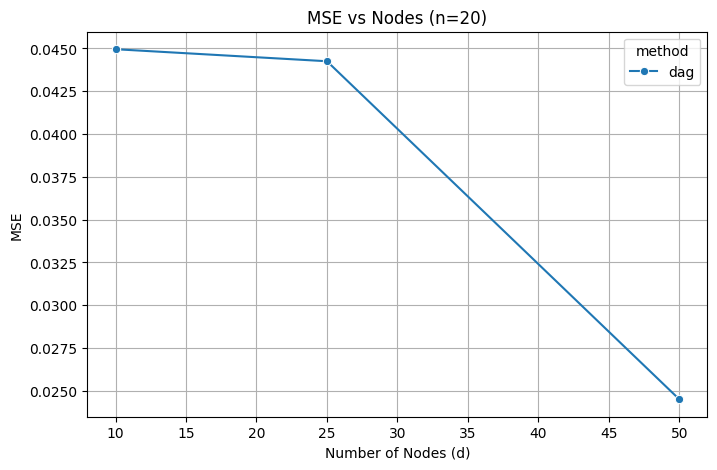

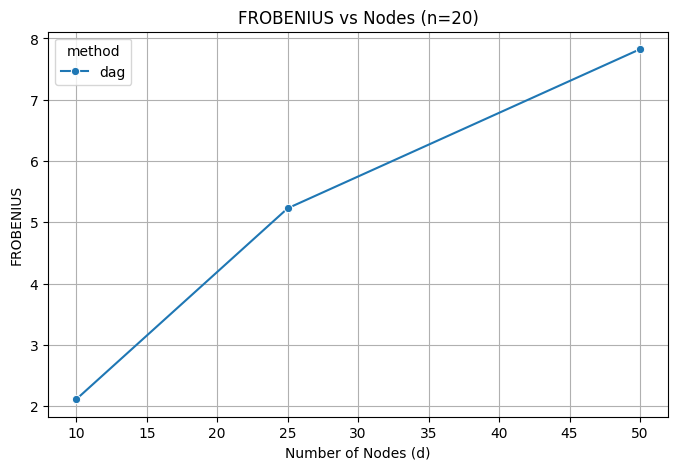

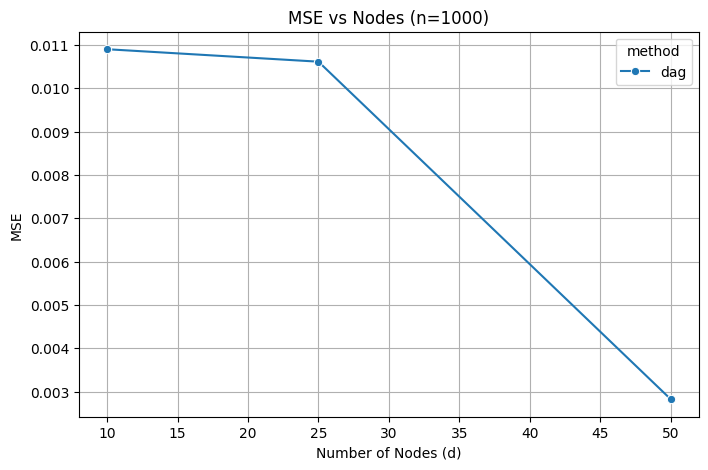

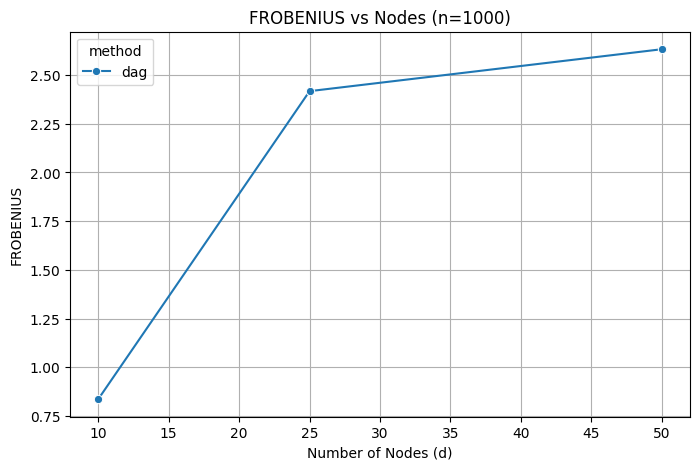

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

metrics = ['mse', 'frobenius']
print(metrics)

for n_val in sample_sizes:
    df_n = df[df['n'] == n_val]
    for metric in metrics:
        plt.figure(figsize=(8, 5))
        sns.lineplot(data=df_n, x='d', y=metric, hue='method', errorbar=None, marker='o')
        plt.title(f"{metric.upper()} vs Nodes (n={n_val})")
        plt.xlabel("Number of Nodes (d)")
        plt.ylabel(metric.upper())
        plt.grid(True)
        plt.savefig(f"{metric}_n{n_val}_s.png", bbox_inches='tight')
        plt.show()
        plt.close()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

all_results3 = []

sample_sizes = [10, 20,50, 100, 200,500, 700, 1000]
node_list = [25]
seeds =[10,  40,  97, 233, 389, 809, 1123]

for n in sample_sizes:
    print(f"Sample Size: {n}")
    for d in node_list:
        print(f"Nodes: {d}")
        s0 = 2 * d  # number of edges
        for seed in seeds:
            set_random_seed(seed)
            print(f"Seed: {seed}")

            B_true = simulate_dag(d, s0, graph_type='ER')
            W_true = simulate_parameter(B_true)
            X,z = simulate_linear_sem(W_true, n, sem_type='gauss',return_noise=True)


            W_unpruned, W_est = linear(X,z, lambda1=0.1, A=0.6, B=0.1, w_threshold=0.1)
            #model = DagmaLinear(loss_type='l2')

            #W_est = model.fit(X, lambda1=0.1)
            mse_no, fro_no = compute_mse_and_frobenius(W_true, W_est)
            acc = count_accuracy(B_true, W_est != 0)
            print(acc)


            for method, acc in [('dag', acc)]:
                all_results3.append({
                    'method': method,
                    'n': n,
                    'd': d,

                    'seed': seed,
                    'fdr': acc['fdr'],
                    'shd': acc['shd'],
                    'edge_intersection': acc['edge_intersection_count']
                })


Sample Size: 10
Nodes: 25
Seed: 10
Accuracy Metrics:
fdr: 0.44
tpr: 0.28
fpr: 0.044
shd: 44
nnz: 25
reverse: 3
false_positive: 8
false_negative: 36
edge_intersection_count: 14
{'fdr': 0.44, 'tpr': 0.28, 'fpr': 0.044, 'shd': 44, 'nnz': 25, 'reverse': 3, 'false_positive': 8, 'false_negative': 36, 'edge_intersection_count': 14}
Seed: 40
Accuracy Metrics:
fdr: 0.6111111111111112
tpr: 0.28
fpr: 0.088
shd: 57
nnz: 36
reverse: 1
false_positive: 21
false_negative: 36
edge_intersection_count: 14
{'fdr': 0.6111111111111112, 'tpr': 0.28, 'fpr': 0.088, 'shd': 57, 'nnz': 36, 'reverse': 1, 'false_positive': 21, 'false_negative': 36, 'edge_intersection_count': 14}
Seed: 97
Accuracy Metrics:
fdr: 0.5588235294117647
tpr: 0.3
fpr: 0.076
shd: 52
nnz: 34
reverse: 2
false_positive: 17
false_negative: 35
edge_intersection_count: 15
{'fdr': 0.5588235294117647, 'tpr': 0.3, 'fpr': 0.076, 'shd': 52, 'nnz': 34, 'reverse': 2, 'false_positive': 17, 'false_negative': 35, 'edge_intersection_count': 15}
Seed: 233
Acc

In [ ]:
df = pd.DataFrame(all_results3)
df.to_csv('dag_nodes_finale.csv', index=False)

In [ ]:
from google.colab import files
files.download('dag_nodes_final.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>